In [1]:
!wget http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz

--2019-02-27 22:00:23--  http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz
Resolving peipa.essex.ac.uk (peipa.essex.ac.uk)... 155.245.93.3
Connecting to peipa.essex.ac.uk (peipa.essex.ac.uk)|155.245.93.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111154265 (106M) [application/gzip]
Saving to: ‘all-mias.tar.gz’

all-mias.tar.gz     100%[===================>] 106.00M  11.3MB/s    in 9.9s    

2019-02-27 22:00:34 (10.7 MB/s) - ‘all-mias.tar.gz’ saved [111154265/111154265]



In [0]:
!tar -xzvf all-mias.tar.gz

In [0]:
with open('Info.txt', 'r') as f:
  rows = f.readlines()
data = {}

for row in rows[103:-2]:
  info = row.replace('\n','').split(' ')
  filename = info[0]+'.pgm'
  if len(info)> 5:
    try:
      annot = [int(x) for x in info[4:]]
      data[filename] = 1
    except:
      continue
  else:
    data[filename] = 0

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

images = []
labels = []

for f in list(data.keys()):
  f = np.random.choice(list(data.keys()))
  img = cv2.imread(f)
  img = cv2.resize(img, (224, 224))
  images.append(img)
  labels.append(data[f])
  #if data[f] != 0:
  #  annot = data[f] 
  #  y , x, r = int(annot[1]), int(annot[2]), int(annot[3])
  #  cv2.circle(img, (x, y), r, (255, 0, 0), 3)
  

In [0]:
!cat Info.txt

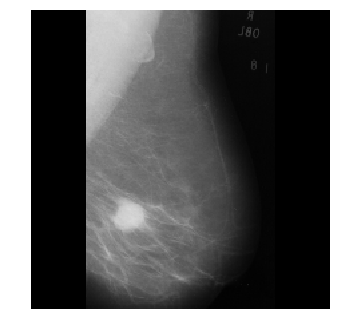

In [6]:
plt.axis('off')
plt.imshow(images[0])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [0]:
X_train = np.array(X_train)
X_test  = np.array(X_test)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D, Input, Concatenate
from keras.layers.normalization import BatchNormalization
import numpy as np
from keras.models import Model

In [0]:
def conv_block(f, in_x, fs = 3):
  x = Conv2D(filters=f, kernel_size=(fs,fs), padding='same', activation = 'relu')(in_x)
  x = Conv2D(filters=f, kernel_size=(fs,fs), padding='same', activation = 'relu')(x)
  
  x = Concatenate(axis = -1)([in_x, x])
  x = MaxPooling2D(pool_size = (2,2))(x)
  return x

In [0]:
def model1():
  # 1st Convolutional Layer
  inp = Input(shape=(224,224,3))

  x = conv_block(16, inp, fs = 3)
  x = conv_block(32, x, fs = 3)
  x = conv_block(64, x)
  x = conv_block(128, x)
  x = conv_block(128, x)
  x = conv_block(256, x)

  x = Flatten()(x)
  x = Dense(256, activation = 'tanh')(x)
  #x = Dropout(0.5)(x)
  x = Dense(1, activation  = 'sigmoid')(x)
  model = Model(inputs = inp, outputs = x)

  # (4) Compile
  model.compile(loss='binary_crossentropy', optimizer='adam',\
   metrics=['accuracy'])
  return model

In [0]:
model = model1()

In [114]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 224, 224, 16) 448         input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 224, 224, 16) 2320        conv2d_150[0][0]                 
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 224, 224, 19) 0           input_21[0][0]                   
                                                                 conv2d_151[0][0]                 
__________

In [0]:
batch_size = 16
steps_per_train = len(X_train)//batch_size
steps_per_test  = len(X_test) //batch_size
model.fit_generator(train_datagen.flow(X_train, y_train), steps_per_epoch = steps_per_train, epochs=20, verbose=1, 
                    validation_data = test_datagen.flow(X_test, y_test), validation_steps = steps_per_test)

Epoch 1/20
15/15 [==============================] - 7s 500ms/step - loss: 1.0031 - acc: 0.5882 - val_loss: 0.7282 - val_acc: 0.5781
Epoch 2/20
15/15 [==============================] - 3s 202ms/step - loss: 0.6084 - acc: 0.6803 - val_loss: 0.7067 - val_acc: 0.5781
Epoch 3/20
15/15 [==============================] - 3s 201ms/step - loss: 0.6029 - acc: 0.6864 - val_loss: 0.6989 - val_acc: 0.6250
Epoch 4/20
15/15 [==============================] - 3s 201ms/step - loss: 0.5643 - acc: 0.7158 - val_loss: 0.8017 - val_acc: 0.5625
Epoch 5/20
15/15 [==============================] - 3s 201ms/step - loss: 0.5775 - acc: 0.7007 - val_loss: 0.6937 - val_acc: 0.5625
Epoch 6/20
15/15 [==============================] - 3s 202ms/step - loss: 0.5323 - acc: 0.7197 - val_loss: 0.8713 - val_acc: 0.6094
Epoch 7/20
15/15 [==============================] - 3s 202ms/step - loss: 0.5321 - acc: 0.7424 - val_loss: 0.7225 - val_acc: 0.5938
Epoch 8/20
15/15 [==============================] - 3s 201ms/step - loss: 0.